## Linear Multi-step methods

Our goal is to implement Adams-Bashforth methods for solving linear differential equations. We focus on the 2nd-order method, but include code for the 4th-order method. Adams-Bashforth methods are called linear multi-step methods because they use a linear combination of function evaluations at multiple timesteps (i.e. a weighted average of values of f at previous time steps). These methods are worth implementing because they have the accuracy of the R-K methods but require less computatation at each step. The drawback is that their regions of stability are quite small, so we may need to take small steps in the interest of stability, rather than accuracy.

In [116]:
import numpy as np
import scipy.integrate
import numpy.linalg
import matplotlib.pyplot as plt

def degradation_model( t, y, params ):
    y1 = y[0]
    y2 = y[1]
    dydt = np.zeros( (2,) )
    dydt[0] = -params[0] * y1
    dydt[1] = -params[1] * y2
    return dydt

In [117]:
def forwardEuler( fn, t, y0, params ):
    """ [t,y] = forwardEuler( fn, t, y0, params )
    Given a function handle fn for dydt, find the value of
    y at timepoints t, given y(0) = y0.
    fn takes t, y, and params as input.
    t is 1-dimensional (NT,)
    y is 2-dimensional (NY,NT)
    """
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        yprime = fn(t[i-1],y[:,i-1],params);
        y[:,i] = y[:,i-1] + h*yprime;
    
    return (t,y)

def explicitTrapezoidal( fn, t, y0, params ):
    """[t,y] = explicitTrapezoidal( fn, t, y0, params )
    Given a function handle fn for y', find the value of
    y at timepoints t, assuming y(0) = y0.
    fn takes t, y, and params as input.
    t is 1-dimensional (NT,)
    y is 2-dimensional (NY,NT)
    """
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        yprime = fn(t[i-1],y[:,i-1],params);
        yhatFE = y[:,i-1] + h*yprime;
        yprimehatFE = fn(t[i],yhatFE,params);
        y[:,i] = y[:,i-1] + h/2*(yprime+yprimehatFE);

    return (t,y)

def RK4( fn, t, y0, params ):
    """
    [t,y] = RK4( fn, t, y0, params )
    Given a function handle fn for y', find the value of
    y at timepoints t, assuming y(0) = y0.
    fn takes t, y, and params as input.
    Uses a 4th order explicit Runge-Kutta method
    """
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        f1 = fn(t[i-1],y[:,i-1],params);
        f2 = fn(t[i-1]+h/2,y[:,i-1]+0.5*h*f1,params);
        f3 = fn(t[i-1]+h/2,y[:,i-1]+0.5*h*f2,params);
        f4 = fn(t[i],y[:,i-1]+h*f3,params);
        y[:,i] = y[:,i-1] + h/6*(f1+2*f2+2*f3+f4);
    return (t,y)

### Implement the method

Use the explicit trapezoidal method to compute the value at the first time step after the initial condition. 

Then, use the Adams-Bashforth method to compute the remaining time steps. Write the code so that the ODE function is called as few times as possible.

\begin{eqnarray*}
f_b &=& f(t-\Delta t,\widehat{y}(t-\Delta t))\\
f_a &=& f(t,\widehat{y}(t))\\
\widehat{y}(t+\Delta t) &=& \widehat{y}(t) + \frac{\Delta t}{2}\left(3f_a-f_b\right)\\
\end{eqnarray*}

In [118]:
def adamsBashforth2( fn, t, y0, params ):
    """
    [t,y] = adamsBashforth2( fn, t, y0, params )
    Given a function handle fn for y', find the value of
    y at timepoints t, assuming y(0) = y0.
    fn takes t, y, and params as input.
    """

    h = t[1]-t[0];
    if abs(np.mean(np.diff(np.diff(t)))) > 1e-8:
        print( 'The time steps must be evenly spaced' );
        return;

    # We need the first two steps. And they need to be computed
    # by a second order method so that the results from this
    # function are second order.
    # So let's use the explicit trapezoidal method
    (tstart,ystart) = explicitTrapezoidal( fn, np.array( [t[0], t[0]+h] ), y0, params );

    y = np.zeros( (y0.size,t.size) )
    y[:,0:2] = ystart;
    f_a = fn(t[0],y[:,0],params)
    for i in range(2,t.size):
        f_b = f_a
        # Compute f at i-1
        f_a = fn(t[i-1],y[:,i-1],params);
        y[:,i] = y[:,i-1] + h/2*(3*f_a-f_b);
                  
    return (t,y)

### Run and plot result from AB2.

Run the AB2 method on the degradation model with degradation rates (2,5) and initial conditions (1,1) with time beginning at 0 and ending at 2.
Stephanie
Then plot the true solution (solid lines) and the forward Euler's solution (dashed lines), explicit Trapezoidal's solution (dotted lines), and AB2's solution (dash-dotted lines).

Then plot the difference over time between the true solution and each of the other methods.

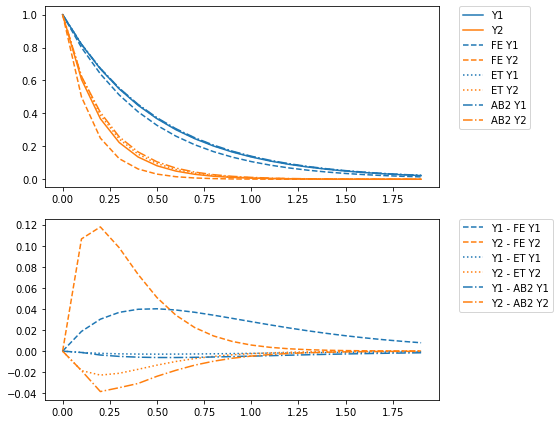

In [107]:
params = (2,5)
y0 = np.array([1,1])
dt = 0.1
t = np.arange(0,2,dt)
(tFE,yFE) = forwardEuler( degradation_model, t, y0, params)
(tET,yET) = explicitTrapezoidal( degradation_model, t, y0, params)
(t,y) = adamsBashforth2( degradation_model, t, np.array([1,1]), params)
tru_y1 = y0[0]*np.exp(-params[0]*t)
tru_y2 = y0[1]*np.exp(-params[1]*t)
tru_y = np.vstack( ( tru_y1, tru_y2) )

plt.figure( figsize = (8,6) )
plt.subplot(2,1,1)
plt.plot( t, tru_y.T )
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( tFE, yFE.T, '--' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( tET, yET.T, ':' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( t, y.T, '-.' );
plt.legend(['Y1','Y2','FE Y1','FE Y2','ET Y1','ET Y2','AB2 Y1','AB2 Y2'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., )

plt.subplot( 2, 1, 2)
plt.plot( t, tru_y.T-yFE.T, '--' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( t, tru_y.T-yET.T, ':' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( t, tru_y.T-y.T, '-.' );
plt.legend(['Y1 - FE Y1','Y2 - FE Y2','Y1 - ET Y1','Y2 - ET Y2','Y1 - AB2 Y1','Y2 - AB2 Y2'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., )
plt.tight_layout()

### Determine how the error depends on the time step size

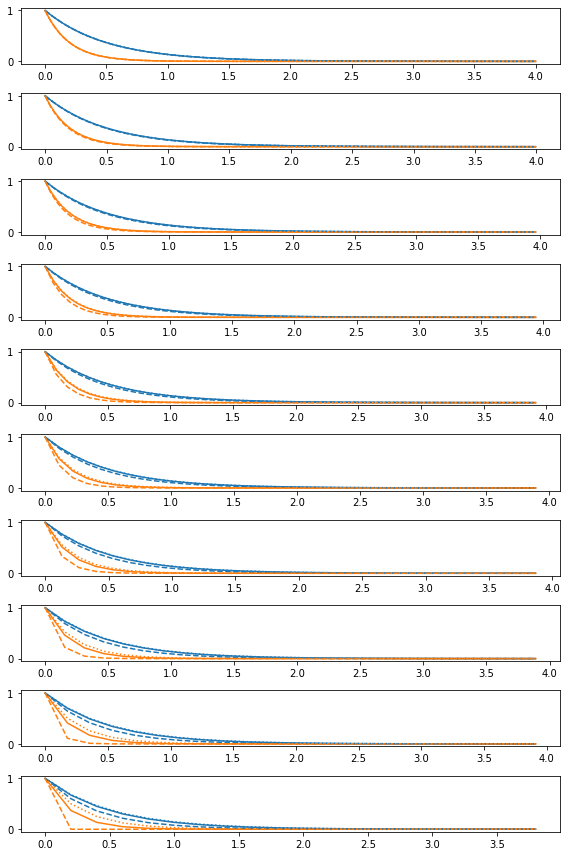

In [108]:
# range from smallest timestep that doesn't take way too long to run to largest time step with qualitatively correct answer.
dts = np.linspace(1e-4,0.2,10)
errFE = np.zeros( (dts.size,) )
errET = np.zeros( (dts.size,) )
errAB2 = np.zeros( (dts.size,) )
params = (2,5)
y0 = np.array((1,1))

plt.figure(figsize=(8,12))
for i in range(dts.size):
    t = np.arange(0,4,dts[i])
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,4), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[params] )
    (t,y) = forwardEuler( degradation_model, t, y0, params)
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    plt.plot( t, y.T, '--')
    errFE[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    (t,y) = explicitTrapezoidal( degradation_model, t, y0, params)
    plt.plot( t, y.T, ':')
    errET[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
    (t,y) = adamsBashforth2( degradation_model, t, y0, params)
    errAB2[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
plt.tight_layout()
    


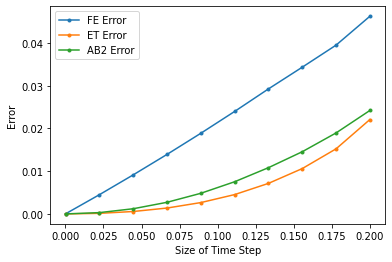

In [109]:
plt.figure()
plt.plot( dts, errFE, 'C0.-' );
plt.plot( dts, errET, 'C1.-' );
plt.plot( dts, errAB2, 'C2.-' );
plt.legend( ['FE Error','ET Error','AB2 Error']);
plt.xlabel( 'Size of Time Step');
plt.ylabel( 'Error');

## Implement AB4

Use the RK4 to compute the value at the first three time steps after the initial condition. 

Then, use the Adams-Bashforth method to compute the remaining time steps. Write the code so that the ODE function is called as few times as possible.

\begin{eqnarray*}
f_d &=& f(t-3\Delta t,\widehat{y}(t-3\Delta t))\\
f_c &=& f(t-2\Delta t,\widehat{y}(t-2\Delta t))\\
f_b &=& f(t-\Delta t,\widehat{y}(t-\Delta t))\\
f_a &=& f(t,\widehat{y}(t))\\
\widehat{y}(t+\Delta t) &=& \widehat{y}(t) + \frac{\Delta t}{24}\left(55f_a-59f_b+37f_c-9f_d\right)\\
\end{eqnarray*}

In [112]:
def adamsBashforth4( fn, t, y0, params ):
    """
    [t,y] = adamsBashforth4( fn, t, y0, params )
    Given a function handle fn for y', find the value of
    y at timepoints t, assuming y(0) = y0.
    fn takes t, y, and params as input.
    Uses an explicit 4th order Adams-Bashforth method
    """
    h = t[1]-t[0];
    if abs(np.mean(np.diff(np.diff(t)))) > 1e-8:
        print( 'The time steps must be evenly spaced' );
        return;


    # We need the first two steps. And they need to be computed
    # by a fourth order method so that the results from this
    # function are fourth order.
    # So let's use the explicit RK4 method
    (tstart,ystart) = RK4( fn, np.array([t[0], t[0]+h, t[0]+2*h, t[0]+3*h]), y0, params );

    a1 = 55/24;
    a2 = 59/24;
    a3 = 37/24;
    a4 = 3/8;
    y = np.zeros( (y0.size,t.size) )
    y[:,0:4] = ystart;
    fc = fn(t[0],y[:,0],params);
    fb = fn(t[1],y[:,1],params);
    fa = fn(t[2],y[:,2],params);
    for i in range(4,t.size):
        fd = fc; fc = fb; fb = fa;
        # Compute f at i-1
        fa = fn(t[i-1],y[:,i-1],params);
        y[:,i] = y[:,i-1] + h*(a1*fa-a2*fb+a3*fc-a4*fd);
                  
    return (t,y)

### Compare AB4 output to RK4 output

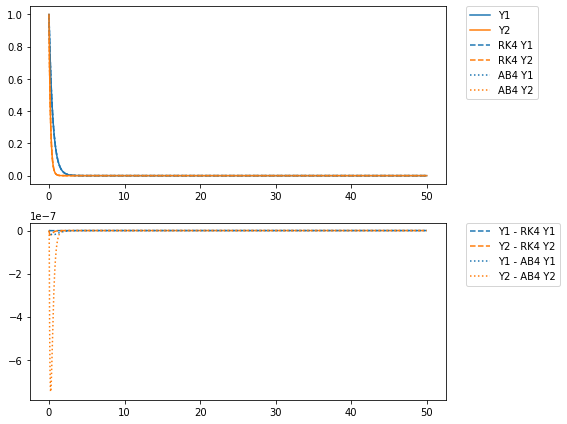

In [113]:
params = (2,5)
y0 = np.array([1,1])
dt = 0.01 # 0.1 is unstable for AB4
t = np.arange(0,50,dt)
(tRK4,yRK4) = RK4( degradation_model, t, np.array([1,1]), params)
(tAB4,yAB4) = adamsBashforth4( degradation_model, t, np.array([1,1]), params)

tru_y1 = y0[0]*np.exp(-params[0]*t)
tru_y2 = y0[1]*np.exp(-params[1]*t)
tru_y = np.vstack( ( tru_y1, tru_y2) )

plt.figure( figsize = (8,6) )
plt.subplot(2,1,1)
plt.plot( t, tru_y.T )
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( tRK4, yRK4.T, '--' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( tAB4, yAB4.T, ':' );
plt.legend(['Y1','Y2','RK4 Y1','RK4 Y2','AB4 Y1','AB4 Y2'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., )

plt.subplot( 2, 1, 2)
plt.plot( t, tru_y.T-yRK4.T, '--' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.plot( t, tru_y.T-yAB4.T, ':' );
plt.gca().set_prop_cycle(None) # this resets the color cycle
plt.legend(['Y1 - RK4 Y1','Y2 - RK4 Y2','Y1 - AB4 Y1','Y2 - AB4 Y2'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., )
plt.tight_layout()

### Determine how the error depends on the time step size

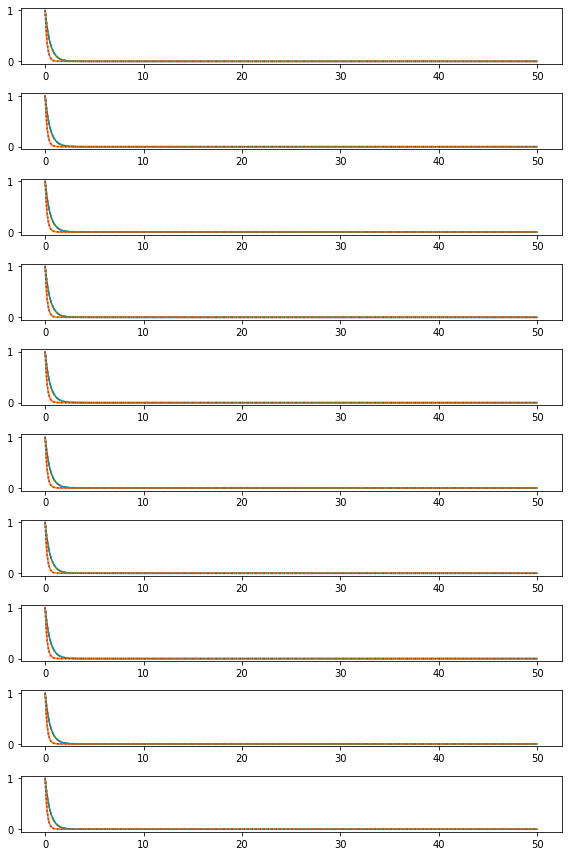

In [114]:
# range from smallest timestep that doesn't take way too long to run to largest time step with qualitatively correct answer.
dts = np.linspace(1e-4,1e-2,10)
errRK4 = np.zeros( (dts.size,) )
errAB4 = np.zeros( (dts.size,) )
params = (2,5)
y0 = np.array((1,1))

plt.figure(figsize=(8,12))
for i in range(dts.size):
    t = np.arange(0,50,dts[i])
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(0,t[-1]), y0=y0, method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[params] )
    (t,y) = RK4( degradation_model, t, y0, params)
    plt.subplot( dts.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    plt.plot( t, y.T, '--')
    errRK4[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
    (t,y) = adamsBashforth4( degradation_model, t, y0, params)
    plt.plot( t, y.T, ':')
    errAB4[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
plt.tight_layout()


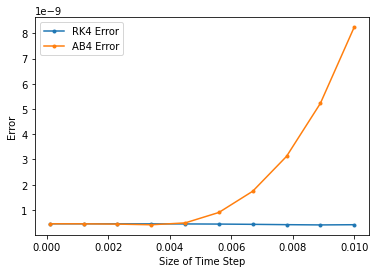

In [115]:
plt.figure()
plt.plot( dts, errRK4, 'C0.-' );
plt.plot( dts, errAB4, 'C1.-' );
plt.legend( ['RK4 Error','AB4 Error']);
plt.xlabel( 'Size of Time Step');
plt.ylabel( 'Error');

## Bonus Code
### Illustrate the trapezoidal rule and AB2 in terms of numerical quadrature

Plot the method computing the area under a known curve (not an ODE).

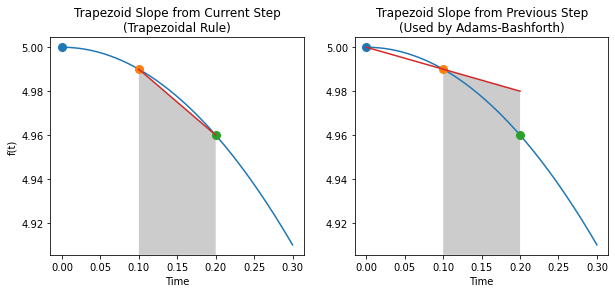

In [104]:
import matplotlib.patches as patches

fn_f = lambda t: 5 + -1*t**2

h = 0.1
eps = 0.2*h
t0,t1,t2,t3 = 0,h,h*2,h*3
tru_t = np.linspace( t0, t0+3*h, 40 )
tru_f = list(map( fn_f, tru_t ));

plt.figure( figsize=(10,4))
ax = plt.subplot( 1, 2, 1 )
plt.plot( tru_t, tru_f )
plt.plot( t0, fn_f(t0), 'C0.', markersize=16)
plt.plot( t1, fn_f(t1), 'C1.', markersize=16)
plt.plot( t2, fn_f(t2), 'C2.', markersize=16)
plt.plot( [t1,t2], [fn_f(t1),fn_f(t2)], 'C3')
yb = plt.ylim()
poly = patches.Polygon([(t1,yb[0]),(t1,fn_f(t1)),(t2,fn_f(t2)),(t2,yb[0])],facecolor='0.8')
ax.add_patch(poly)
plt.title( 'Trapezoid Slope from Current Step\n(Trapezoidal Rule)')
plt.ylabel( 'f(t)')
plt.xlabel( 'Time')


ax = plt.subplot( 1, 2, 2 )
plt.plot( tru_t, tru_f )
plt.plot( t0, fn_f(t0), 'C0.', markersize=16)
plt.plot( t1, fn_f(t1), 'C1.', markersize=16)
plt.plot( t2, fn_f(t2), 'C2.', markersize=16)
slope = (fn_f(t1)-fn_f(t0))/h
plt.plot( [t0,t2], [fn_f(t0),fn_f(t0)+slope*2*h], 'C3');
yb = plt.ylim()
poly = patches.Polygon([(t1,yb[0]),(t1,fn_f(t0)+slope*h),(t2,fn_f(t0)+slope*2*h),(t2,yb[0])],facecolor='0.8')
ax.add_patch(poly)
plt.title( 'Trapezoid Slope from Previous Step\n(Used by Adams-Bashforth)');
plt.xlabel( 'Time');




### Examine steps taken by AB2

Use the slope at previous steps to get the final slope estimate for the current step.

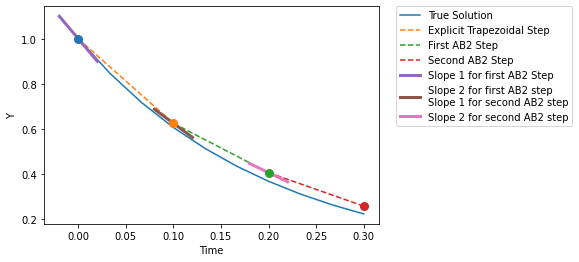

In [120]:
fn = lambda t, y, params: -params[0]*y
params = (5,)
y0 = 1
h = 0.1
eps = 0.2*h
t0,t1,t2,t3 = 0,h,h*2,h*3
tru_t = np.linspace( t0, t0+3*h, 10 )
tru_y = y0*np.exp(-params[0]*tru_t)

# use explicit trapezoidal to get first two points
yprime = fn(t0,y0,params);
yhatFE = y0 + h*yprime;
yprimehatFE = fn(t1,yhatFE,params);
y1 = y0 + h/2*(yprime+yprimehatFE);

# Compute f at i-1
fim1 = fn(t1,y1,params);
# Compute f at i-2
fim2 = fn(t0,y0,params);
y2 = y1 + h/2*(3*fim1-fim2);

# Compute f at i+1
fim0 = fn(t2,y2,params);
y3 = y2 + h/2*(3*fim0-fim1);

plt.plot( tru_t, tru_y.T, 'C0' );
plt.plot( [t0,t1], [y0,y1], 'C1--' );
plt.plot( [t1,t2], [y1,y2], 'C2--' );
plt.plot( [t2,t3], [y2,y3], 'C3--' );
plt.plot( [t0-eps,t0+eps], [y0-eps*fim2,y0+eps*fim2], 'C4', linewidth=3)
plt.plot( [t1-eps,t1+eps], [y1-eps*fim1,y1+eps*fim1], 'C5', linewidth=3)
plt.plot( [t2-eps,t2+eps], [y2-eps*fim0,y2+eps*fim0], 'C6', linewidth=3)

plt.plot( t0, y0, 'C0.', markersize=16)
plt.plot( t1, y1, 'C1.', markersize=16)
plt.plot( t2, y2, 'C2.', markersize=16)
plt.plot( t3, y3, 'C3.', markersize=16)

plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., 
           labels=['True Solution','Explicit Trapezoidal Step','First AB2 Step',
                   'Second AB2 Step','Slope 1 for first AB2 Step',
                   'Slope 2 for first AB2 step\nSlope 1 for second AB2 step',
                   'Slope 2 for second AB2 step']);
plt.xlabel( 'Time')
plt.ylabel( 'Y');